<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
## openEO Platform UC6 - Near Real Time Forest Dynamics
### Author michele.claus@eurac.edu
### Date: 2021/10/12

### Import all the libraries and utilities functions

In [ ]:
from eo_utils import *

### Connect and login

In [ ]:
openeoHost = "https://openeo.eurac.edu"
conn = openeo.connect(openeoHost).authenticate_oidc(client_id="openEO_PKCE")

# Where do you want to detect changes?
Select the area of interest from the map using the rectangle tool

In [ ]:
center = [46.35, 11.45]
zoom = 12
eoMap = openeoMap(center,zoom)
eoMap.map

In [ ]:
bbox = eoMap.getBbox()
print("Coordinates selected from map:",'\n west',bbox[0],'\n east',bbox[2],'\n south',bbox[1],'\n north',bbox[3])

## Sentinel-2 data pre-processing (cloud masking, data clipping)

Sentinel-2 data loading

In [ ]:
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
temporal_extent = ["2016-09-01", "2018-09-01"] # This is the reference period
collection      = 'S2_L2A_T32TPS'
bands           = ["B02_10m","B03_10m","B04_10m",'B08_10m','B8A_20m']

l2a_bands = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent)

s2cloudless data loading

In [ ]:
collection      = 's2cloudless_alps'
cloud_band      = conn.load_collection(collection,spatial_extent=spatial_extent,temporal_extent=temporal_extent)

In [ ]:
args_resample_cube_temporal= {"data": THIS,"method": "nearest","target": l2a_bands}
cloud_band_resampled = cloud_band.process("resample_cube_temporal",args_resample_cube_temporal)

Create a boolean mask using s2cloudless, where the cloud mask > 0

In [ ]:
cloud_band_resampled = cloud_band_resampled.apply(lambda x: x.gt(0))

Apply a the dilation operation to the cloud mask, to cover a slightly bigger area. https://en.wikipedia.org/wiki/Dilation_%28morphology%29

We use the apply_kernel process from openEO https://processes.openeo.org/#apply_kernel

In [ ]:
cloud_band_dilated = cloud_band_resampled.apply_kernel(np.ones((5, 5)))

Apply the cloud mask to the Sentinel-2 bands

In [ ]:
l2a_bands_masked = l2a_bands.mask(mask=cloud_band_dilated,replacement=0)

Clip the data to avoid unmasked clouds

In [ ]:
l2a_bands_masked_clipped = l2a_bands_masked.apply(lambda x: x.clip(0,5000))

# Seasonal curve fitting

The following formula models a seasonal harmonic behavior, typical of vegetation:
```
a0+a1*cos(2*pi/31557600*x)+a2*sin(2*pi/31557600*x)
```
31557600 are the seconds in one year. The values that x will assume are Unix timesteps (seconds from 01-01-1970).

The forests should follow this seasonal behaviour and the fitted function should get close to the real signal like in the following example:

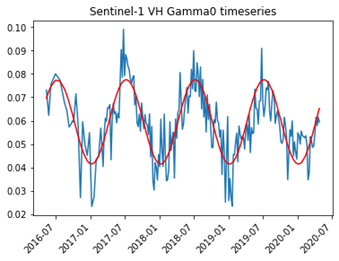

In [ ]:
def fitFunction(x:ProcessBuilder, parameters:ProcessBuilder):
    t = 2 * math.pi / 31557600 * x
    return parameters[0] + parameters[1] * cos(t) + parameters[2] * sin(t)

curve_fitting = l2a_bands_masked_clipped.fit_curve(
    parameters=[1,1,1], # Initial guess of the parameters
    dimension="t",      # Fit the function along the temporal dimension
    function=fitFunction
)

Save the result parameters as a netCDF for later use and start the batch job

In [ ]:
fitted_parameters = curve_fitting.save_result(format="NetCDF")

In [ ]:
job = fitted_parameters.send_job(title = "S2_curve_fitting_12102021",out_format = "NetCDF")
jobIdFitting = job.job_id
job.start_job()

Check the fitting job status and when it is marked as 'finished', you can continue

In [ ]:
jobIdFitting = "90c6ef07-9ba7-466d-86e5-05e3dc3fca49"

## Curve prediction

Given the computed parameters stored in a netCDF from the previous job, we can now reuse them, predicting the values in the training period when following the sinuisoidal behavior.

With the difference between predicted and real data, we compute the RMSE over the training period and finally the standard deviation over time, resulting in a final raster with a single band and no time dimension.

Load result parameters from previous job

In [ ]:
curve_fitting_loaded = conn.load_result(id=jobIdFitting)

Compute the predicted values

In [ ]:
curve_prediction = l2a_bands_masked_clipped.predict_curve(parameters=curve_fitting_loaded,dimension='t',function=fitFunction)

Mask out the cloud covered areas as in the original training data

In [ ]:
predicted_masked = curve_prediction.mask(mask=cloud_band_dilated,replacement=0)

Subtract the predicted values from the pre-processed S-2 data

In [ ]:
merged_cubes = l2a_bands_masked_clipped.merge_cubes(predicted_masked,overlap_resolver=subtract)

Compute the RMSE

In [ ]:
from change_detection_utils import compute_residual

bands = ["B02_10m","B03_10m","B04_10m","B08_10m","B8A_20m"]
rmse = compute_residual(merged_cubes,bands)

Compute the standard deviation of the residual error over time

In [ ]:
rmse_std = rmse.reduce_dimension(dimension='DATE',reducer=sd)

Save the resulting layer as netCDF and start the batch job

In [ ]:
rmse_std_netcdf = rmse_std.save_result(format="NetCDF")

In [ ]:
job = rmse_std_netcdf.send_job(title = "S2_curve_predicting_08092021")
jobIdPredicting = job.job_id
job.start_job()

In [ ]:
jobIdPredicting = "051edcc7-6b81-4b19-adca-ea5ebc87a474"

Check the predicting job status and when it is marked as 'finished', you can continue

In [ ]:
conn.job(jobIdPredicting)

## Interactive exploration of the data and the fitted models

Select a single point from the map and run the following cell to view how the seasonal model fits the data

In [ ]:
center = [46.35, 11.45]
zoom = 12
eoMap2 = openeoMap(center,zoom)
eoMap2.map

In [ ]:
%%time
from change_detection_utils import download_raw_and_predicted
filename= "swir.nc"
band = "B09_60m"
temporal_extent = ["2016-09-01", "2019-09-01"]
temporal_extent_reference = ["2016-09-01", "2018-09-01"]
download_raw_and_predicted(conn,"S2_L2A_T32TPS",eoMap2.point_coords,temporal_extent,temporal_extent_reference,band,filename)

In [ ]:
xr.open_dataarray('swir.nc').dims

In [ ]:
addTimeseries(eoMap2,filename,[band,band+"_predicted"],True)

In [ ]:
data = xr.open_dataarray(filename)
data.loc[dict(variable='B09_60m')].mean(dim=['x','y']).plot()
data.loc[dict(variable='B09_60m_predicted')].mean(dim=['x','y']).plot()

# Visualization of real and predicted data

Given the seasonal model, we can predict new data which should follow the harmonic trend.

We can understand this process more easily looking side by side at what we would see if the data would follow the seaonal behavior perfectly, compared with real data.

In [ ]:
from change_detection_utils import download_rgb_and_predicted
rgb_bands = ["B02_10m","B03_10m","B04_10m"]
rgb_temporal_extent = ["2019-08-01","2019-08-15"]
filename = "l2a_rgb_composite.png"
download_rgb_and_predicted(conn,"S2_L2A_T32TPS",spatial_extent,rgb_temporal_extent,rgb_bands,filename,"f8ea2429-2309-42df-ab05-e67f45bf925b")
addImageLayer(eoMap2,filename,spatial_extent,"original RGB")
addImageLayer(eoMap2,filename.split('.')[0]+"_pred.png",spatial_extent,"model RGB")
eoMap2.map

# Change detection

Given the fitted function to each pixel, we can find out how much the signal deviates from the model and flag it as a change when it goes beyond a threshold.

The following example shows how noticeable is the change in the SAR (Sentinel-1) signal after the Vaia storm of a forest area affected from it.

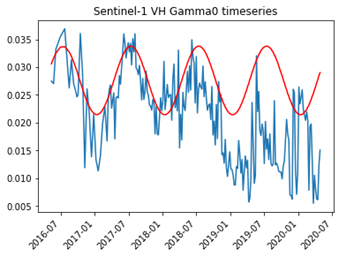

TIP: If you want to use the same bbox as a previously executed job, you can use the following function to retrieve the spatial extent, using the corresponding job id:

In [ ]:
from change_detection_utils import get_bbox_from_job
job = conn.job(jobIdFitting)
spatial_extent = get_bbox_from_job(job)
print(spatial_extent)

In [ ]:
# jobIdPredicting = ""
# jobIdFitting = ""

Load precomputed std layer

In [ ]:
training_std_loaded = conn.load_result(id=jobIdPredicting)

Load the testing data and filter it in the same way as we did for training

In [ ]:
temporal_extent_test = ["2018-10-01", "2019-05-01"] # This is the testing period
collection           = 'S2_L2A_T32TPS'
bands                = ["B02_10m","B03_10m","B04_10m",'B08_10m','B8A_20m']

l2a_bands_test = conn.load_collection(collection,spatial_extent=spatial_extent,bands=bands,temporal_extent=temporal_extent_test)

In [ ]:
collection      = 's2cloudless_alps'
cloud_bands = conn.load_collection(collection,spatial_extent=spatial_extent,temporal_extent=temporal_extent_test)

In [ ]:
args_resample_cube_temporal= {"data": THIS,"method": "nearest","target": l2a_bands_test}
cloud_bands_resampled = cloud_bands.process("resample_cube_temporal",args_resample_cube_temporal)

In [ ]:
cloud_bands_resampled = cloud_bands_resampled.apply(lambda x: x.gt(0))

In [ ]:
cloud_band_dilated = cloud_bands_resampled.apply_kernel(np.ones((5, 5)))

In [ ]:
l2a_bands_masked = l2a_bands_test.mask(mask=cloud_band_dilated,replacement=0)

In [ ]:
l2a_bands_masked_clipped = l2a_bands_masked.apply(lambda x: x.clip(0,5000))

Predict the values that the test data should have following the seasonal trend

In [ ]:
curve_fitting_loaded = PGNode("load_result", id=jobIdFitting)

In [ ]:
curve_prediction = l2a_bands_masked_clipped.predict_curve(parameters=curve_fitting_loaded,dimension='t',function=fitFunction)

In [ ]:
predicted_masked = curve_prediction.mask(mask=cloud_band_dilated,replacement=0)

In [ ]:
merged_cubes = l2a_bands_masked_clipped.merge_cubes(predicted_masked,overlap_resolver=subtract)

Compute the residual error

In [ ]:
from change_detection_utils import compute_residual
bands           = ["B02_10m","B03_10m","B04_10m","B08_10m","B8A_20m"]
residual        = compute_residual(merged_cubes,bands)

Load precomputed std layer

In [ ]:
training_std_loaded = conn.load_result(id=jobIdPredicting)

### Set the thresold for the change detection
We raise and alarm if residual error > 3*std

It is not mandatory to use 3 as multiplicative factor, it depends on the signal and how big are deviations from the model that we want to detect.

In [ ]:
change_threshold = 3
alarm_threshhold = training_std_loaded.apply(lambda x: x * change_threshold)

In [ ]:
alarm_cubes = residual.merge_cubes(alarm_threshhold,overlap_resolver=gt)

Save the timeseries of detected changes as netCDF and start the batch job

In [ ]:
alarm_cubes_netcdf = alarm_cubes.save_result(format="NetCDF")

In [ ]:
job = alarm_cubes_netcdf.send_job(title = "S2_alarms_12102021")
jobIdAlarms = job.job_id
job.start_job()

Check the alamrs job status and when it is marked as 'finished', you can continue

In [ ]:
job

Download the result

In [ ]:
jobAlarms = conn.job(jobIdAlarms)
jobResults = jobAlarms.get_results()
jobResults.download_files('./S2_alarms_12102021')

# Visualization of detected changes

We consider and visualize a detected change only if there are 3 subsequent changes detected. You can modify the value of subsequentAlarms with a bigger or smaller amount and see what changes.

If monthlyAggregate=True, we compute the aggregation of the detected changes for each month. If your testing period covers more than 12 months, the aggregation will be performed over all the data for the month (Jan,Feb,...), independently from which year.

In [ ]:
from change_detection_utils import plot_detected_changes
plot_detected_changes(netcdfPath='./S2_alarms_12102021/result.nc',monthlyAggregate=True,subsequentAlarms=3,backgroundTiles='OSM',timeDim='time') #Try 'ESRI' as backgroundTiles for satellite RGB background

## SAR data - Sentinel-1

Sentinel-1 data loading: we use load_result to load a preprocessed datacube

In [ ]:
temporal_extent = ["2016-09-01", "2018-09-01"] # This is the training period
bands           = ["VV","VH"]
collection      = 'SAR2Cube_L0_117_ASC_ST_2016_2020_IFG_LIA_DEM'
sar_data = conn.load_collection(collection)
intensity_data = sar_data.process("load_result", id="84e0fd74-da48-4662-9587-45f33da9568b") # This id refers to a specific reault to be loaded, don't change it

In [ ]:
intensity_data = intensity_data.filter_temporal(temporal_extent).filter_bbox(spatial_extent)

In [ ]:
from change_detection_utils import seasonal_curve_fitting
curve_fitting = seasonal_curve_fitting(intensity_data)

Save the result parameters as a netCDF for later use and start the batch job

In [ ]:
fitted_parameters = curve_fitting.save_result(format="NetCDF")

In [ ]:
job = fitted_parameters.send_job(title = "S1_curve_fitting_09092021",out_format = "NetCDF")
jobIdFitting = job.job_id
job.start_job()

Check the fitting job status and when it is marked as 'finished', you can continue

In [ ]:
conn.list_jobs()

In [ ]:
curve_fitting_loaded = PGNode("load_result", id=jobIdFitting)

In [ ]:
from change_detection_utils import seasonal_curve_predicting
curve_prediction = seasonal_curve_predicting(intensity_data,curve_fitting_loaded)

In [ ]:
merged_cubes = intensity_data.merge_cubes(curve_prediction,overlap_resolver=subtract)
merged_cubes = merged_cubes.rename_labels("bands",["VV","VH"])

In [ ]:
from change_detection_utils import compute_residual
bands           = ["VV","VH"]
rmse = compute_residual(merged_cubes,bands)

In [ ]:
rmse_std = rmse.reduce_dimension(dimension='DATE',reducer=sd)

In [ ]:
rmse_std_netcdf = rmse_std.save_result(format="NetCDF")

In [ ]:
job = rmse_std_netcdf.send_job(title = "S1_curve_predicting_09092021")
jobIdPredicting = job.job_id
job.start_job()

Check the predicting job status and when it is marked as 'finished', you can continue

In [ ]:
conn.job(jobIdPredicting)

## Interactive exploration of the data and the fitted models

Select a single point from the map and run the following cell to view how the seasonal model fits the data

In [ ]:
eoMap2.map

In [ ]:
%%time
from change_detection_utils import download_S1_raw_and_predicted
filename= "VH_band.nc"
band = "VH"
temporal_extent = ["2016-09-01", "2019-09-01"] # This is the testing period
temporal_extent_reference = ["2016-09-01", "2018-09-01"] # This is the testing period
download_S1_raw_and_predicted(conn,"84e0fd74-da48-4662-9587-45f33da9568b",eoMap2.point_coords,temporal_extent,temporal_extent_reference,band,filename)

In [ ]:
addTimeseries(eoMap2,filename,[band,band+"_predicted"],True)

In [ ]:
# To visualize an interactive plot uncomment the next line
# xr.open_dataset(filename).mean(dim=['x','y']).hvplot.scatter(legend='top_right',dynamic=False,width=800,height=300)

# Change detection

In [ ]:
# jobIdPredicting = ""
# jobIdFitting = ""

Load precomputed std layer

In [ ]:
training_std_loaded = PGNode("load_result", id=jobIdPredicting)

Load the testing data and filter it in the same way as we did for the reference period

In [ ]:
temporal_extent_test = ["2018-10-01", "2019-09-01"] # This is the testing period
# spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3]}
bands           = ["VV","VH"]
collection      = 'SAR2Cube_L0_117_ASC_ST_2016_2020_IFG_LIA_DEM'
sar_data = conn.load_collection(collection)
intensity_data = sar_data.process("load_result", id="84e0fd74-da48-4662-9587-45f33da9568b").filter_temporal(temporal_extent_test).filter_bbox(spatial_extent)

Predict the values that the test data should have following the seasonal trend

In [ ]:
curve_fitting_loaded = PGNode("load_result", id=jobIdFitting)

In [ ]:
from change_detection_utils import seasonal_curve_predicting
curve_prediction = seasonal_curve_predicting(intensity_data,curve_fitting_loaded)

In [ ]:
merged_cubes = intensity_data.merge_cubes(curve_prediction,overlap_resolver=subtract).rename_labels("bands",["VV","VH"])

Compute the residual error

In [ ]:
from change_detection_utils import compute_residual
residual = compute_residual(merged_cubes,bands)

Load precomputed std layer

In [ ]:
training_std_loaded = intensity_data.process("load_result", id=jobIdPredicting)

### Set the thresold for the change detection
We raise and alarm if residual error > 3*std

It is not mandatory to use 3 as multiplicative factor, it depends on the signal and how big are deviations from the model that we want to detect.

In [ ]:
change_threshold = 2
alarm_threshhold = training_std_loaded.apply(lambda x: x * change_threshold)

In [ ]:
alarm_cubes = residual.merge_cubes(alarm_threshhold,overlap_resolver=gt)

Save the timeseries of detected changes as netCDF and start the batch job

In [ ]:
alarm_cubes_netcdf = alarm_cubes.save_result(format="NetCDF")

In [ ]:
job = alarm_cubes_netcdf.send_job(title = "S1_alarms_09092021")
jobIdAlarms = job.job_id
job.start_job()

Check the alamrs job status and when it is marked as 'finished', you can continue

In [ ]:
conn.list_jobs()

Download the result

In [ ]:
jobAlarms = conn.job(jobIdAlarms)
jobResults = jobAlarms.get_results()
jobResults.download_files('./S1_result')

# Visualization of detected changes

In [ ]:
s1_alarms = xr.open_dataarray("./S1_result/result.nc")
s1_alarms['crs'] = 32632
s1_alarms.to_netcdf("./S1_result/s1_result_with_epsg.nc")

In [ ]:
plot_detected_changes(netcdfPath='./S1_result/s1_result_with_epsg.nc',monthlyAggregate=False,subsequentAlarms=3,backgroundTiles='OSM')
#Try 'ESRI' as backgroundTiles for satellite RGB background